In [1]:
# reading data in order to perform statistical inferences
# the data is saved as Apache Parquet, a columnar storage format

! wget https://github.com/IBM/coursera/raw/master/hmp.parquet

# create a spark dataframe
df = spark.read.parquet('hmp.parquet')

# register a query table
df.createOrReplaceTempView('df')

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200212183002-0000
KERNEL_ID = 089f771a-5e23-4e60-a189-e335a9309aa1
--2020-02-12 18:30:05--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/coursera/master/hmp.parquet [following]
--2020-02-12 18:30:05--  https://raw.githubusercontent.com/IBM/coursera/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (911K) [application/octet-stream]
Saving to: 'hmp.parquet'

100%[======================================>] 932,997     --.-K/s   in 0.04s   

2020-02-12 18:30:06 (21.3 MB/s

In [6]:
df.show(5)

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
+---+---+---+--------------------+-----------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- z: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- class: string (nullable = true)



In [11]:
# check if the target vairable class is balanced or not
spark.sql('select class, count(*) as count from df group by class').show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone|15225|
| Standup_chair|25417|
|      Eat_meat|31236|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|     Comb_hair|23504|
|          Walk|92254|
|  Climb_stairs|40258|
| Sitdown_chair|25036|
|   Liedown_bed|11446|
|Descend_stairs|15375|
|   Brush_teeth|29829|
|      Eat_soup| 6683|
+--------------+-----+



In [12]:
# let's check the class by using dataFrame api
df.groupby('class').count().show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone|15225|
| Standup_chair|25417|
|      Eat_meat|31236|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|     Comb_hair|23504|
|          Walk|92254|
|  Climb_stairs|40258|
| Sitdown_chair|25036|
|   Liedown_bed|11446|
|Descend_stairs|15375|
|   Brush_teeth|29829|
|      Eat_soup| 6683|
+--------------+-----+



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
counts = df.groupby('class').count().orderBy('count').toPandas()
counts.head()

,class,count
0,Eat_soup,6683
1,Liedown_bed,11446
2,Use_telephone,15225
3,Descend_stairs,15375
4,Comb_hair,23504


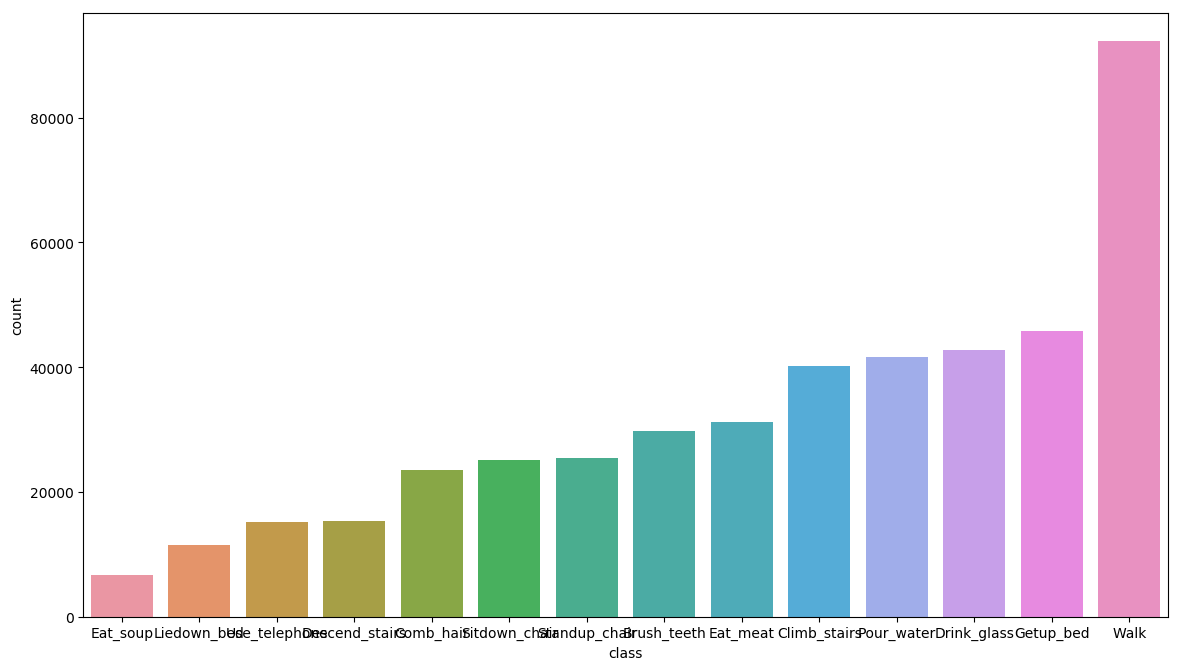

In [32]:
plt.figure(figsize=(14,8), dpi=100)
sns.barplot(x='class', y='count',  data=counts)
plt.show()

In [33]:
# let's obtain some statistics from spark.sql

spark.sql("""
    select
    *,
    max/min as maxmin_ratio
    from (
        select
        min(count) as min,
        max(count) as max,
        mean(count) as mean,
        stddev(count) as stddev
        from (
            select
            count(*) as count
            from
            df
            group by
            class
            )
        )
          """).show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|     maxmin_ratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



In [38]:
from pyspark.sql.functions import col, min, max, mean, stddev

# do same thing based on dataframe api
df.groupBy('class').count() \
    .select([
        min(col('count')).alias('min'),
        max(col('count')).alias('max'),
        mean(col('count')).alias('mean'),
        stddev(col('count')).alias('stddev')
    ]) \
    .select([
        col('*'),
        (col('max') / col('min')).alias('maxmin_ratio')
    ]).show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|     maxmin_ratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



In [40]:
# create a table of all classes with their counts, and ordered by counts, ascending
spark.sql("""
    select
    *
    from (
        select
        class,
        count(*) as count
        from
        df
        group by
        class
    )
    order by
    count asc
""").show()

+--------------+-----+
|         class|count|
+--------------+-----+
|      Eat_soup| 6683|
|   Liedown_bed|11446|
| Use_telephone|15225|
|Descend_stairs|15375|
|     Comb_hair|23504|
| Sitdown_chair|25036|
| Standup_chair|25417|
|   Brush_teeth|29829|
|      Eat_meat|31236|
|  Climb_stairs|40258|
|    Pour_water|41673|
|   Drink_glass|42792|
|     Getup_bed|45801|
|          Walk|92254|
+--------------+-----+



In [41]:
# do the same operation based on dataframe api
df.groupBy('class').count().orderBy('count').show()

+--------------+-----+
|         class|count|
+--------------+-----+
|      Eat_soup| 6683|
|   Liedown_bed|11446|
| Use_telephone|15225|
|Descend_stairs|15375|
|     Comb_hair|23504|
| Sitdown_chair|25036|
| Standup_chair|25417|
|   Brush_teeth|29829|
|      Eat_meat|31236|
|  Climb_stairs|40258|
|    Pour_water|41673|
|   Drink_glass|42792|
|     Getup_bed|45801|
|          Walk|92254|
+--------------+-----+



Imbalanced data can cause pain in machine learning. Therefore, let's do rebalance. In the following we limit the number of elements per class to the amont of least represented class. This is called undersampling. Other ways of rebalancing can be found here:

http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [42]:
# create a lots of distinct dataset from df
# get the data as a list
classes = [row[0] for row in df.select('class').distinct().collect()]

In [43]:
# compute the counts of the smallest the group
minimum = df.groupBy('class').count().select(min(col('count'))).first()[0]
print(minimum)

6683


In [44]:
classes

['Use_telephone',
 'Standup_chair',
 'Eat_meat',
 'Getup_bed',
 'Drink_glass',
 'Pour_water',
 'Comb_hair',
 'Walk',
 'Climb_stairs',
 'Sitdown_chair',
 'Liedown_bed',
 'Descend_stairs',
 'Brush_teeth',
 'Eat_soup']

In [49]:
# create a balanced dataframe

df_balanced = None

for cls in classes:
    
    df_temp = df.filter(f'class = "{cls}"').sample(False, 1.0).limit(minimum)
    
    if df_balanced == None:
        df_balanced = df_temp
    else:
        df_balanced = df_balanced.union(df_temp)


In [51]:
df_balanced.createOrReplaceTempView('df_balanced')
spark.sql("""
    select
    class,
    count(*)
    from
    df_balanced
    group by
    class
""").show()

+--------------+--------+
|         class|count(1)|
+--------------+--------+
| Use_telephone|    6683|
| Standup_chair|    6683|
|      Eat_meat|    6683|
|     Getup_bed|    6683|
|   Drink_glass|    6683|
|    Pour_water|    6683|
|     Comb_hair|    6683|
|          Walk|    6683|
|  Climb_stairs|    6683|
| Sitdown_chair|    6683|
|   Liedown_bed|    6683|
|Descend_stairs|    6683|
|   Brush_teeth|    6683|
|      Eat_soup|    6683|
+--------------+--------+

